In [1]:
import polars as pl
import os
from pathlib import Path
import pandas as pd
import hvplot.polars
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay



sso_data = Path.cwd().parent / "Data/Option_data/SSO_complete.csv"
parquet_file = (Path.cwd().parent / "Data/Option_data/SSO_complete")

data_path = Path.cwd().parent / "Data"

#Restrictions
timeperiod = [datetime.datetime(2019, 1, 1), datetime.datetime(2021, 12, 31)]
volume_r = 0
open_interest_r = 0
delta_r = 0
vega_r = 0
theta_r = 0
gamma_r = 0
midprice_r = 0.3
bid_price_r = 0.0
days_till_exp_r1 = 7
days_till_exp_r2 = 252
moneyness_min = -8
moneyness_max = 5



In [2]:
# pl.read_csv(sso_data, separator = ",").estimated_size("mb")

In [3]:
df = pl.scan_csv(sso_data, separator=",")
df.schema
df.fetch(1000)

date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,ticker,index_flag,issuer,div_convention,exercise_style
str,str,str,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,i64,str,i64,str,str,str
"""2016-01-04""","""2016-01-08""","""C""",1000000,0.0,0.49,0,0,1.692439,0.006994,0.000173,1.300576,-100.3955,109965553,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",400000,234.75,238.15,0,0,null,null,null,null,null,109965554,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",410000,224.5,228.2,0,0,null,null,null,null,null,109965555,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",420000,214.75,218.3,0,0,null,null,null,null,null,109965556,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-01-08""","""C""",430000,204.35,208.3,0,0,null,null,null,null,null,109965557,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2016-01-04""","""2016-02-05""","""C""",702500,11.8,12.45,2,3,0.451222,0.253848,0.003764,60.37361,-156.1969,110256313,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-02-05""","""C""",705000,11.25,12.0,20,10,0.45159,0.245625,0.003696,59.31837,-153.6006,110256314,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""
"""2016-01-04""","""2016-02-05""","""C""",710000,10.15,10.75,71,62,0.448326,0.227372,0.003567,56.89643,-146.123,110256315,"""AMZN""",0,"""AMAZON.COM INC…",null,"""A"""


# Lower the data by use of efficiency and formatting

In [4]:
#Desired data types for the columns
int_cols = ["strike_price", "volume", "open_interest"]
float_cols = ["best_bid", "best_offer", "impl_volatility", "delta", "gamma", "vega", "theta", "forward_price"]
datetime_cols = ["date","exdate"]
str_cols = ["cp_flag", "ticker", "exercise_style"]
drop_cols = ["optionid", "index_flag", "issuer", "div_convention", "exercise_style"]

In [5]:
#one line to do all the above
df = df.with_columns(
    [ pl.col(int_cols).cast(pl.Int64),
      pl.col(float_cols).cast(pl.Float64),
      pl.col(datetime_cols).cast(pl.Date),
      pl.col(str_cols).cast(pl.String),
    ]
).drop(drop_cols)

## Apply filter for volume and open interest

In [6]:
# Saving file
data_path_parq = Path.cwd().parent / "Data/Option_data/sso_complete.parquet"

save_parquet = False
if save_parquet or not os.path.exists(data_path_parq):
    df.sink_parquet(data_path_parq)

# Applying the different filters 
- Time period from 2019 - 2022
- 0 to 7 days experiy
- moneyness from 0.8 to 1.2

In [7]:
df2 = pl.read_parquet(data_path_parq)

dfp = df2.to_pandas()

#Create 1-day before IV
dfp['Prev_day_IV'] = dfp.groupby(['ticker', 'strike_price'])['impl_volatility'].shift(1).fillna(0)

df = pl.from_pandas(dfp)

# #Creating a filter for missing greeks
# df = df.filter((pl.col("delta") > delta_r) | (pl.col("gamma") > gamma_r) | (pl.col("vega") > vega_r) | (pl.col("theta") > theta_r))

# Creating the date filter period
df = df.filter(
    pl.col("exdate").is_between(timeperiod[0], timeperiod[1]),
)
df = df.filter(
    pl.col("date").is_between(timeperiod[0], timeperiod[1]),
)

In [8]:
dfp = df.to_pandas()

# Create a custom business day object that excludes weekends and US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Calculate the number of business days between 'date' and 'exdate'
def business_days_diff(start_date, end_date, business_day_offset):
    return np.busday_count(start_date.date(), end_date.date(), busdaycal=business_day_offset.holidays)

# Get US federal holidays within the range
holidays = USFederalHolidayCalendar().holidays(start=dfp['date'].min(), end=dfp['exdate'].max())

# Convert holidays to numpy datetime64 array
holidays = holidays.to_numpy(dtype='datetime64[D]')

# Calculate the difference in business days for each row
dfp['trading_days_till_exp'] = np.busday_count(dfp['date'].values.astype('datetime64[D]'),
                                               dfp['exdate'].values.astype('datetime64[D]'),
                                               holidays=holidays)


In [9]:
dfp

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,Prev_day_IV,trading_days_till_exp
0,2019-01-02,2019-01-04,C,1000000,534.05,543.00,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.357581,2
1,2019-01-02,2019-01-04,C,1010000,524.05,533.00,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.356683,2
2,2019-01-02,2019-01-04,C,1020000,514.55,523.00,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.356243,2
3,2019-01-02,2019-01-04,C,1030000,504.00,513.00,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.402529,2
4,2019-01-02,2019-01-04,C,1040000,494.00,503.00,0,0,NaN,NaN,NaN,NaN,NaN,AMZN,0.354683,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15809894,2021-12-31,2021-12-31,P,445000,107.90,108.90,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
15809895,2021-12-31,2021-12-31,P,450000,112.75,114.00,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
15809896,2021-12-31,2021-12-31,P,460000,123.20,123.55,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0
15809897,2021-12-31,2021-12-31,P,470000,133.20,133.55,0,0,NaN,NaN,NaN,NaN,NaN,META,0.000000,0


In [10]:
# # Creating the days_till_experire collumn and filter time to maturity
# df = df.with_columns(
#     days_till_exp = pl.col("exdate").cast(pl.Date) - pl.col("date").cast(pl.Date)
# ).sort("cp_flag").sort("date")

# df = df.with_columns(
#     days_till_exp = pl.col("days_till_exp").dt.days()
# )
df = pl.from_pandas(dfp)


df = df.filter(pl.col("trading_days_till_exp") <= days_till_exp_r2)

# #Creating a filter for the volume and open_interest
df = df.filter((pl.col("volume") > volume_r))

# #Create filter for bid higher than ask price
df = df.filter(pl.col("best_bid") <= pl.col("best_offer"))
df = df.filter(pl.col("best_bid") >= bid_price_r)

# Filter out rows where 'impl_volatility' is missing
df = df.filter(pl.col("impl_volatility").is_not_null())

# #Creating a midprices column
# df = df.with_columns(
#     bid_diff = pl.col("best_offer").sub(pl.col("best_bid").cast(pl.Float64)) 
# ).sort("cp_flag").sort("date")

# #Filter for the midprice
# # df = df.filter(pl.col("bid_diff") <= midprice_r)



## Create a graph of the days till expiry and implied volatility of a specific stock for a strike price

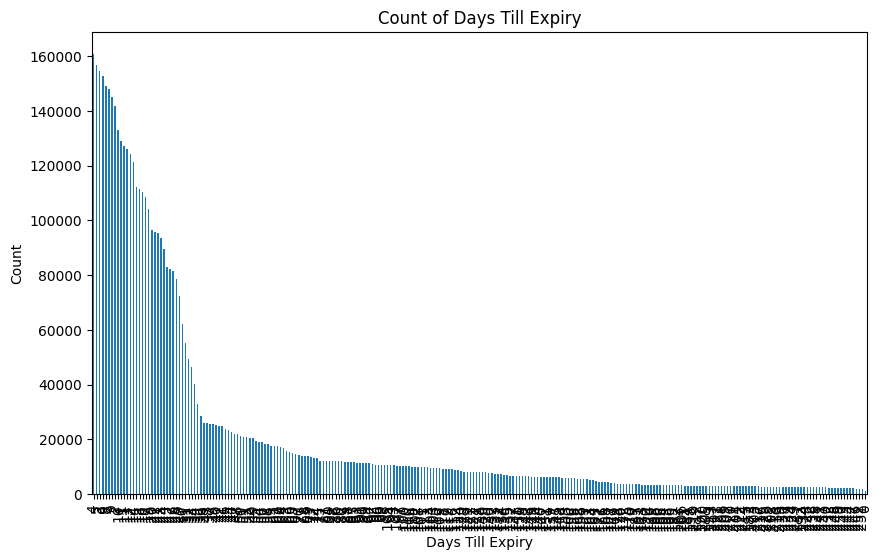

In [11]:
# Get the counts of 'days_till_exp'
df_pandas = df.to_pandas()

counts = df_pandas['trading_days_till_exp'].value_counts()

# Create the bar plot
counts.plot(kind='bar', figsize=(10, 6))
plt.title('Count of Days Till Expiry')
plt.xlabel('Days Till Expiry')
plt.ylabel('Count')
plt.show()

# Merging the stock prices with the options

In [12]:
# Reading the stock data
stock_path_parq = Path.cwd().parent / "Data/Stock_data/stock_data.parquet"
df_stock = pl.read_parquet(stock_path_parq)

# Convert Polars dataframes to pandas
df = df.to_pandas()
df_stock = df_stock.to_pandas()

# Ensure that 'date' is a datetime object in both dataframes
df['date'] = pd.to_datetime(df['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])

# Rename the 'TICKER' column in df_stock to 'ticker' to match df
df_stock = df_stock.rename(columns={'TICKER': 'ticker'})

# Merge 'RET' column from df_stock into df
merged_df = pd.merge(df, df_stock[['ticker', 'date', 'PRC', 'PRC_actual']], on=['ticker', 'date'], how='left')


In [13]:
merged_df.sort_values(by='trading_days_till_exp')



,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,ticker,Prev_day_IV,trading_days_till_exp,PRC,PRC_actual
4786299,2021-11-11,2021-11-12,C,155000,0.00,0.01,1325,13483,0.325874,0.006143,0.006863,0.135333,-8.036966,WMT,0.203040,0,148.50000,49.500000
4118664,2021-11-11,2021-11-12,P,2650000,0.00,0.05,1,190,1.539917,-0.000344,0.000004,0.227242,-64.209410,AMZN,0.000000,0,3472.50000,173.625000
4118663,2021-11-11,2021-11-12,P,2490000,0.00,0.05,2,9,1.871271,-0.000286,0.000003,0.190900,-65.633580,AMZN,0.000000,0,3472.50000,173.625000
4118662,2021-11-11,2021-11-12,C,4950000,0.00,0.01,12,638,1.758710,0.000071,0.000001,0.050953,-16.686860,AMZN,0.280177,0,3472.50000,173.625000
4118661,2021-11-11,2021-11-12,C,4850000,0.00,0.01,85,94,1.663921,0.000074,0.000001,0.053407,-16.556980,AMZN,0.280014,0,3472.50000,173.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618651,2019-09-18,2020-09-18,C,165000,4.00,4.25,10,630,0.219534,0.251630,0.010446,43.971340,-5.401990,MSFT,0.207913,252,138.52000,138.520000
618652,2019-09-18,2020-09-18,C,180000,1.65,1.81,50,578,0.209256,0.129891,0.007276,29.239800,-3.359059,MSFT,0.192346,252,138.52000,138.520000
618653,2019-09-18,2020-09-18,C,200000,0.44,0.57,4,1038,0.203663,0.046519,0.003445,13.482950,-1.481577,MSFT,0.000000,252,138.52000,138.520000
543704,2019-01-16,2020-01-17,P,97500,6.70,6.90,79,4581,0.264658,-0.322812,0.012957,37.419680,-3.931706,MSFT,0.269502,252,105.38000,105.380000


## Create the forward price of the stocks

In [14]:
# Load the existing firm and market data
df_firm = merged_df  # Replace with your path
df_macro = pd.read_parquet(Path.cwd().parent / "Data/Macroeconomic_variables/merged_marcofirm.parquet")  # Replace with your path

# Load the dividend data
df_dividends = pd.read_csv(Path.cwd().parent / 'Data/Stock_data/Dividend_Data_2019_2022.csv')  # Replace with your path

# Convert the DATE column to datetime format for easy merging
df_macro['DATE'] = pd.to_datetime(df_macro['DATE'])

# Calculate the annual dividend yield by grouping by ticker and summing the dividends per year
df_dividends['Date'] = pd.to_datetime(df_dividends['Date'])
df_dividends['Year'] = df_dividends['Date'].dt.year
annual_dividends = df_dividends.groupby(['Ticker', 'Year'])['Amount'].sum().reset_index()
annual_dividends['Annual_Dividend_Yield'] = annual_dividends['Amount'] / df_firm['PRC']

# Merge the annual dividend yield back to the firm data
df_firm['Year'] = df_firm['date'].dt.year
df_firm = df_firm.rename(columns={'ticker': 'Ticker'})
df_firm = df_firm.merge(annual_dividends[['Ticker', 'Year', 'Annual_Dividend_Yield']], 
                        on=['Ticker', 'Year'], how='left')

# Fill NaN values in 'Annual_Dividend_Yield' with 0
df_firm['Annual_Dividend_Yield'] = df_firm['Annual_Dividend_Yield'].fillna(0)

# Calculate time to maturity in years
df_firm['T'] = df_firm['trading_days_till_exp'] / 252

# Interpolate the 2Y bond rates for exact dates of the firm data
df_firm['DATE'] = df_firm['date']
df_firm = df_firm.merge(df_macro[['DATE', '2Y_bond']], on='DATE', how='left')
df_firm['2Y_bond'].interpolate(method='time', inplace=True)

# Convert '2Y_bond' and 'Annual_Dividend_Yield' to float
df_firm['2Y_bond'] = df_firm['2Y_bond'].astype(float)
df_firm['Annual_Dividend_Yield'] = df_firm['Annual_Dividend_Yield'].astype(float)

# Calculate forward prices using the formula F = P * e^(r - q)T
df_firm['Forward_Price'] = df_firm['PRC'] * np.exp(((df_firm['2Y_bond']/100) - df_firm['Annual_Dividend_Yield']) * df_firm['T'])

# Save the updated dataframe with the Forward Price column
# updated_file_path = "/mnt/data/Updated_Firm_Data.csv"
# df_firm.to_csv(updated_file_path, index=False)


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/1560370389.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_firm['2Y_bond'].interpolate(method='time', inplace=True)
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/1560370389.py:32: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_firm['2Y_bond'].interpolate(method='time', inplace=True)


In [15]:
df = df_firm


# Function to calculate the ATM IV and add it to the DataFrame
def add_atm_iv(df):
    # Sort DataFrame to ensure correct grouping
    df = df.sort_values(by=['date', 'exdate', 'strike_price'])
    
    # Group by 'date' and 'PRC', here 'PRC' is assumed to be the relevant column for grouping
    grouped = df.groupby(['exdate', 'Forward_Price'])
    
    atm_iv_list = []
    
    # Iterate over each group
    for name, group in grouped:
        # Find the row with the strike price closest to PRC_actual
        group['strike_diff'] = abs((group['strike_price']/1000) - group['Forward_Price'])
        atm_row = group.loc[group['strike_diff'].idxmin()]
        
        # The ATM implied volatility for this group
        atm_iv = atm_row['impl_volatility']
        
        # Assign this ATM IV to all rows in the group
        group['atm_impl_volatility'] = atm_iv
        
        # Append to the list
        atm_iv_list.append(group)
    
    # Concatenate all the groups back into a single DataFrame
    result_df = pd.concat(atm_iv_list)
    
    # Drop the temporary 'strike_diff' column
    result_df = result_df.drop(columns=['strike_diff'])
    
    return result_df

# Applying the function to the DataFrame
df_with_atm_iv = add_atm_iv(df)

print(df_with_atm_iv)

              date     exdate cp_flag  strike_price  best_bid  best_offer  \
954403  2019-01-03 2019-01-04       P         70000      0.00        0.02   
954404  2019-01-03 2019-01-04       P         80000      0.00        0.02   
954405  2019-01-03 2019-01-04       P         83500      0.00        0.02   
954406  2019-01-03 2019-01-04       P         85000      0.00        0.01   
954407  2019-01-03 2019-01-04       P         86000      0.00        0.02   
...            ...        ...     ...           ...       ...         ...   
4127180 2021-11-18 2021-12-31       C       4800000      4.35        6.30   
4127181 2021-11-18 2021-12-31       C       4850000      3.90        5.75   
4127182 2021-11-18 2021-12-31       C       4900000      3.50        5.30   
4127183 2021-11-18 2021-12-31       C       4950000      3.15        4.90   
4127184 2021-11-18 2021-12-31       C       5000000      2.82        4.00   

         volume  open_interest  impl_volatility     delta  ...  \
954403   

In [16]:
df_with_atm_iv.sort_values(by='trading_days_till_exp')

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,trading_days_till_exp,PRC,PRC_actual,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility
4697197,2021-11-11,2021-11-12,P,2380000,0.60,1.80,5,36,0.469102,-0.047170,...,0,2479.04004,2479.04004,2021,0.0,0.0,2021-11-11,0.5956,2479.040040,0.350981
4118651,2021-11-11,2021-11-12,C,4390000,0.00,0.03,6,74,1.279786,0.000263,...,0,3472.50000,173.62500,2021,0.0,0.0,2021-11-11,0.5956,3472.500000,0.242704
4118806,2021-11-11,2021-11-12,P,4390000,911.90,928.50,2,5,2.120697,-0.980170,...,0,3472.50000,173.62500,2021,0.0,0.0,2021-11-11,0.5956,3472.500000,0.242704
4118652,2021-11-11,2021-11-12,C,4400000,0.00,0.03,4,270,1.291286,0.000261,...,0,3472.50000,173.62500,2021,0.0,0.0,2021-11-11,0.5956,3472.500000,0.242704
4118653,2021-11-11,2021-11-12,C,4450000,0.01,0.02,52,220,1.348280,0.000251,...,0,3472.50000,173.62500,2021,0.0,0.0,2021-11-11,0.5956,3472.500000,0.242704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3566706,2020-06-17,2021-06-18,C,280000,17.45,17.85,8,1128,0.345519,0.375130,...,252,235.53000,235.53000,2020,0.0,1.0,2020-06-17,0.2351,236.084382,0.371202
3566707,2020-06-17,2021-06-18,C,285000,16.00,16.60,19,630,0.344061,0.354779,...,252,235.53000,235.53000,2020,0.0,1.0,2020-06-17,0.2351,236.084382,0.371202
3566708,2020-06-17,2021-06-18,C,290000,14.70,15.25,10,980,0.341921,0.334436,...,252,235.53000,235.53000,2020,0.0,1.0,2020-06-17,0.2351,236.084382,0.371202
3566696,2020-06-17,2021-06-18,C,215000,45.70,46.55,2,388,0.386821,0.668735,...,252,235.53000,235.53000,2020,0.0,1.0,2020-06-17,0.2351,236.084382,0.371202


## Create the moneyness column

In [17]:
merged_df = df_with_atm_iv 

merged_df['moneyness'] = np.log((merged_df['strike_price']/1000) / merged_df['Forward_Price']) / \
                       (np.sqrt(merged_df['T']) * merged_df['atm_impl_volatility'])

# Optionally save the updated DataFrame to a new CSV
# df_firm.to_csv('updated_dataframe_with_moneyness.csv', index=False)

# Print the DataFrame or specific columns to verify the moneyness calculations
print(merged_df[['strike_price', 'Forward_Price', 'T', 'Prev_day_IV', 'moneyness']])

         strike_price  Forward_Price         T  Prev_day_IV  moneyness
954403          70000      92.868553  0.003968     2.853282 -13.300500
954404          80000      92.868553  0.003968     1.667636  -7.017875
954405          83500      92.868553  0.003968     1.266451  -5.003203
954406          85000      92.868553  0.003968     1.136790  -4.165499
954407          86000      92.868553  0.003968     1.018112  -3.615202
...               ...            ...       ...          ...        ...
4127180       4800000    3698.594681  0.115079     0.285033   2.867516
4127181       4850000    3698.594681  0.115079     0.000000   2.981515
4127182       4900000    3698.594681  0.115079     0.000000   3.094346
4127183       4950000    3698.594681  0.115079     0.000000   3.206030
4127184       5000000    3698.594681  0.115079     0.000000   3.316593

[5478771 rows x 5 columns]


## Create the trading_day column

In [18]:
# Sort the DataFrame by date
merged_df = merged_df.sort_values('date')

# Create a new column 'trading_day' that ranks each unique date
merged_df['trading_day'] = merged_df['date'].rank(method='dense').astype(int)

# Create a few filters for the dataframe and an overview

In [19]:
#Create moneyness filter
pl_merged = pl.from_pandas(merged_df)

pl_merged = pl_merged.filter((pl.col("moneyness") >= moneyness_min) & (pl.col("moneyness") <= moneyness_max))

pd_merged = pl_merged.to_pandas()


In [20]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,PRC_actual,Year,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day
0,2019-01-02,2019-01-11,P,255000,0.95,0.99,320,193,0.814218,-0.054890,...,20.674667,2019,0.0,0.027778,2019-01-02,2.5442,310.339246,0.614092,-1.918955,1
1,2019-01-02,2019-01-18,C,119000,0.55,0.75,2,48,0.297967,0.177300,...,111.980000,2019,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.861277,1
2,2019-01-02,2019-01-18,C,120000,0.40,0.60,22,2599,0.297155,0.143901,...,111.980000,2019,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1
3,2019-01-02,2019-01-18,P,120000,8.40,8.70,16,3202,0.320693,-0.841136,...,111.980000,2019,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1
4,2019-01-02,2019-01-18,C,130000,0.00,0.10,7,2532,0.332273,0.018084,...,111.980000,2019,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,2.139078,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307415,2021-12-30,2021-12-31,P,1145000,74.80,76.40,45,180,0.783864,-0.947740,...,356.779990,2021,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.385904,756
5307416,2021-12-30,2021-12-31,C,1150000,0.38,0.39,33831,14807,0.700020,0.026135,...,356.779990,2021,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756
5307417,2021-12-30,2021-12-31,P,1150000,79.80,81.40,343,567,0.823729,-0.949898,...,356.779990,2021,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756
5307418,2021-12-30,2021-12-31,C,1155000,0.35,0.36,3587,1556,0.725706,0.023568,...,356.779990,2021,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.693742,756


In [21]:
df = pd_merged

# Define maturity ranges for tau (τ)
bins = [0, 5, 20, 60, float('inf')]  # upper bounds are exclusive except the last
labels = ['τ ≤ 5', '5 < τ ≤ 20', '20 < τ ≤ 60', 'τ > 60']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define m categories based on delta (adjust as needed)
def classify_m(delta):
    if delta < -2:
        return 'm < -2'
    elif -2 <= delta <= 2:
        return '|m| ≤ 2'
    else:
        return 'm > 2'

df['m_category'] = df['moneyness'].apply(classify_m)

# Calculate Number of Contracts (%) and Volume (%)
# Group by maturity group and m category, then calculate counts and volume sums
summary = df.groupby(['maturity_group', 'm_category']).agg(
    Number_of_contracts=pd.NamedAgg(column='date', aggfunc='count'),  # Assuming each row is a contract
    Volume=pd.NamedAgg(column='volume', aggfunc='sum')
)

# Calculate percentages
total_contracts = summary['Number_of_contracts'].sum()
total_volume = summary['Volume'].sum()
summary['Number_of_contracts (%)'] = (summary['Number_of_contracts'] / total_contracts) * 100
summary['Volume (%)'] = (summary['Volume'] / total_volume) * 100

# Pivot table with reset index for adding totals
result = summary.pivot_table(index='maturity_group', columns='m_category', 
                             values=['Number_of_contracts (%)', 'Volume (%)'], 
                             fill_value=0).swaplevel(axis=1).sort_index(axis=1)

# Add totals across all columns and rows
result.loc['Total', :] = result.sum()
result['Total'] = result.sum(axis=1)

print(result)

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/911364670.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['maturity_group', 'm_category']).agg(


m_category                      m < -2                              m > 2  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ ≤ 5                         3.237901   4.049459                1.908460   
5 < τ ≤ 20                    5.661451   1.978925                3.085605   
20 < τ ≤ 60                   3.851928   0.813480                1.664952   
τ > 60                        2.466095   0.340055                0.432395   
Total                        15.217375   7.181918                7.091412   

m_category                                |m| ≤ 2                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ ≤ 5            3.369371                7.060681  49.029938   68.655810  
5 < τ ≤ 20       1.248255               25.457435  22.808205   60.239876  
20 < τ ≤

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/911364670.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  result = summary.pivot_table(index='maturity_group', columns='m_category',


In [22]:
result

m_category                      m < -2                              m > 2  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ ≤ 5                         3.237901   4.049459                1.908460   
5 < τ ≤ 20                    5.661451   1.978925                3.085605   
20 < τ ≤ 60                   3.851928   0.813480                1.664952   
τ > 60                        2.466095   0.340055                0.432395   
Total                        15.217375   7.181918                7.091412   

m_category                                |m| ≤ 2                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ ≤ 5            3.369371                7.060681  49.029938   68.655810  
5 < τ ≤ 20       1.248255               25.457435  22.808205   60.239876  
20 < τ ≤ 60      0.418474               24.519446  11.130746   42.399026  
τ > 60           0.075997               20.653651   4.737096   28.705288  
Total            5.112096               77.691213  87.705985  200.000000

In [23]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2019-01-02,2019-01-11,P,255000,0.95,0.99,320,193,0.814218,-0.054890,...,0.0,0.027778,2019-01-02,2.5442,310.339246,0.614092,-1.918955,1,5 < τ ≤ 20,|m| ≤ 2
1,2019-01-02,2019-01-18,C,119000,0.55,0.75,2,48,0.297967,0.177300,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.861277,1,5 < τ ≤ 20,|m| ≤ 2
2,2019-01-02,2019-01-18,C,120000,0.40,0.60,22,2599,0.297155,0.143901,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,|m| ≤ 2
3,2019-01-02,2019-01-18,P,120000,8.40,8.70,16,3202,0.320693,-0.841136,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,|m| ≤ 2
4,2019-01-02,2019-01-18,C,130000,0.00,0.10,7,2532,0.332273,0.018084,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,2.139078,1,5 < τ ≤ 20,m > 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307415,2021-12-30,2021-12-31,P,1145000,74.80,76.40,45,180,0.783864,-0.947740,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.385904,756,τ ≤ 5,m > 2
5307416,2021-12-30,2021-12-31,C,1150000,0.38,0.39,33831,14807,0.700020,0.026135,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307417,2021-12-30,2021-12-31,P,1150000,79.80,81.40,343,567,0.823729,-0.949898,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307418,2021-12-30,2021-12-31,C,1155000,0.35,0.36,3587,1556,0.725706,0.023568,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.693742,756,τ ≤ 5,m > 2


In [24]:
import pandas as pd
import plotly.graph_objects as go

# Create a copy of pd_merged
pd_merged_copy = pd_merged.copy()

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Use the copy for the filtering
pd_merged_2 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10) & (pd_merged_copy["m_category"] == "|m| ≤ 2") & (pd_merged_copy['cp_flag'] == 'P')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = pd_merged_2[(pd_merged_2['Ticker'] == 'AMZN') & (pd_merged_2['date'] == date)]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_nvda['moneyness'],
    y=df_nvda['trading_days_till_exp'],
    z=df_nvda['impl_volatility'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_nvda['impl_volatility'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [25]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2019-01-02,2019-01-11,P,255000,0.95,0.99,320,193,0.814218,-0.054890,...,0.0,0.027778,2019-01-02,2.5442,310.339246,0.614092,-1.918955,1,5 < τ ≤ 20,|m| ≤ 2
1,2019-01-02,2019-01-18,C,119000,0.55,0.75,2,48,0.297967,0.177300,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.861277,1,5 < τ ≤ 20,|m| ≤ 2
2,2019-01-02,2019-01-18,C,120000,0.40,0.60,22,2599,0.297155,0.143901,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,|m| ≤ 2
3,2019-01-02,2019-01-18,P,120000,8.40,8.70,16,3202,0.320693,-0.841136,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,|m| ≤ 2
4,2019-01-02,2019-01-18,C,130000,0.00,0.10,7,2532,0.332273,0.018084,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,2.139078,1,5 < τ ≤ 20,m > 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307415,2021-12-30,2021-12-31,P,1145000,74.80,76.40,45,180,0.783864,-0.947740,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.385904,756,τ ≤ 5,m > 2
5307416,2021-12-30,2021-12-31,C,1150000,0.38,0.39,33831,14807,0.700020,0.026135,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307417,2021-12-30,2021-12-31,P,1150000,79.80,81.40,343,567,0.823729,-0.949898,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307418,2021-12-30,2021-12-31,C,1155000,0.35,0.36,3587,1556,0.725706,0.023568,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.693742,756,τ ≤ 5,m > 2


In [26]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2019-01-02,2019-01-11,P,255000,0.95,0.99,320,193,0.814218,-0.054890,...,0.0,0.027778,2019-01-02,2.5442,310.339246,0.614092,-1.918955,1,5 < τ ≤ 20,|m| ≤ 2
1,2019-01-02,2019-01-18,C,119000,0.55,0.75,2,48,0.297967,0.177300,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.861277,1,5 < τ ≤ 20,|m| ≤ 2
2,2019-01-02,2019-01-18,C,120000,0.40,0.60,22,2599,0.297155,0.143901,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,|m| ≤ 2
3,2019-01-02,2019-01-18,P,120000,8.40,8.70,16,3202,0.320693,-0.841136,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,|m| ≤ 2
4,2019-01-02,2019-01-18,C,130000,0.00,0.10,7,2532,0.332273,0.018084,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,2.139078,1,5 < τ ≤ 20,m > 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307415,2021-12-30,2021-12-31,P,1145000,74.80,76.40,45,180,0.783864,-0.947740,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.385904,756,τ ≤ 5,m > 2
5307416,2021-12-30,2021-12-31,C,1150000,0.38,0.39,33831,14807,0.700020,0.026135,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307417,2021-12-30,2021-12-31,P,1150000,79.80,81.40,343,567,0.823729,-0.949898,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307418,2021-12-30,2021-12-31,C,1155000,0.35,0.36,3587,1556,0.725706,0.023568,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.693742,756,τ ≤ 5,m > 2


In [27]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import plotly.graph_objects as go

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Create a copy of pd_merged
pd_merged_copy = pd_merged.copy()

# Use the copy for the filtering
pd_merged_1 = pd_merged_copy[(pd_merged_copy["trading_days_till_exp"] <= 10) & (pd_merged_copy["m_category"] == "|m| ≤ 2") & (pd_merged_copy['cp_flag'] == 'C')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df__nvda = pd_merged_1[(pd_merged_1['Ticker'] == 'AMZN') & (pd_merged_1['date'] == date)]

# Create a grid of x and y values
x = np.linspace(df__nvda['moneyness'].min(), df__nvda['moneyness'].max(), len(df__nvda['moneyness'].unique()))
y = np.linspace(df__nvda['trading_days_till_exp'].min(), df__nvda['trading_days_till_exp'].max(), len(df__nvda['trading_days_till_exp'].unique()))
x_grid, y_grid = np.meshgrid(x, y)

# Interpolate z values
z_grid = griddata((df__nvda['moneyness'], df__nvda['trading_days_till_exp']), df__nvda['impl_volatility'], (x_grid, y_grid), method='cubic')

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis')])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [28]:
pd_merged_1

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
503,2019-01-02,2019-01-11,C,1420000,125.00,129.00,28,127,0.460519,0.876641,...,0.0,0.027778,2019-01-02,2.5442,1540.218122,0.411215,-1.185762,1,5 < τ ≤ 20,|m| ≤ 2
506,2019-01-02,2019-01-11,C,1415000,129.50,137.50,69,14,0.504430,0.866202,...,0.0,0.027778,2019-01-02,2.5442,1540.218122,0.411215,-1.237229,1,5 < τ ≤ 20,|m| ≤ 2
509,2019-01-02,2019-01-11,C,1410000,134.00,140.25,2,27,0.491297,0.881408,...,0.0,0.027778,2019-01-02,2.5442,1540.218122,0.411215,-1.288878,1,5 < τ ≤ 20,|m| ≤ 2
511,2019-01-02,2019-01-11,C,1425000,120.50,128.50,6,27,0.493329,0.851029,...,0.0,0.027778,2019-01-02,2.5442,1540.218122,0.411215,-1.134476,1,5 < τ ≤ 20,|m| ≤ 2
513,2019-01-02,2019-01-11,C,1402500,140.50,148.50,32,53,0.509701,0.886634,...,0.0,0.027778,2019-01-02,2.5442,1540.218122,0.411215,-1.366697,1,5 < τ ≤ 20,|m| ≤ 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307400,2021-12-30,2021-12-31,C,1110000,1.65,1.70,20698,3831,0.562583,0.111212,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,1.286889,756,τ ≤ 5,|m| ≤ 2
5307402,2021-12-30,2021-12-31,C,1115000,1.31,1.39,8845,2144,0.578058,0.090887,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,1.445996,756,τ ≤ 5,|m| ≤ 2
5307404,2021-12-30,2021-12-31,C,1120000,1.10,1.14,18980,6240,0.596979,0.075603,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,1.604391,756,τ ≤ 5,|m| ≤ 2
5307406,2021-12-30,2021-12-31,C,1125000,0.91,0.95,8841,2906,0.615086,0.062945,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,1.762080,756,τ ≤ 5,|m| ≤ 2


## Plots of the data

In [29]:
z_grid

array([[0.414737  , 0.41141299, 0.41373609, 0.42243036, 0.42466625,
        0.41501433, 0.40668168, 0.40591852, 0.40673342, 0.40604277,
        0.40441354, 0.40256028, 0.40112129, 0.40015573, 0.39945697,
        0.39881699, 0.39804639, 0.39701624, 0.3958913 , 0.39539356,
        0.39529095, 0.39404344, 0.39182628, 0.39033012, 0.38984705,
        0.38979417, 0.38957672, 0.38875135, 0.38744702, 0.3859279 ,
        0.38445745, 0.38326484, 0.38252909, 0.38242526, 0.38306626,
        0.3839339 , 0.38414254, 0.38280219, 0.38000522, 0.37905072,
        0.38108554, 0.3818909 , 0.37962469, 0.3759748 , 0.37283107,
        0.37171602, 0.37162412, 0.37093903, 0.36975512, 0.36873834,
        0.36886942, 0.36982775, 0.36977198, 0.36861704, 0.36751124,
        0.36693977, 0.36666615, 0.3649342 , 0.36190348, 0.36182771,
        0.36460085, 0.36542015, 0.36424182, 0.36351054, 0.36304504,
        0.36215095, 0.36104   , 0.36008591, 0.35963851, 0.35938812,
        0.35865908, 0.35772026, 0.35703394, 0.35

In [30]:
df__nvda

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
47924,2019-01-11,2019-01-25,C,1642500,41.10,42.00,59,4,0.325648,0.511247,...,0.0,0.035714,2019-01-11,2.5709,1642.067079,0.325648,0.004283,8,5 < τ ≤ 20,|m| ≤ 2
47926,2019-01-11,2019-01-25,C,1640000,42.75,43.40,89,92,0.327988,0.520800,...,0.0,0.035714,2019-01-11,2.5709,1642.067079,0.325648,-0.020468,8,5 < τ ≤ 20,|m| ≤ 2
47928,2019-01-11,2019-01-25,C,1637500,44.10,44.70,7,1,0.328589,0.530246,...,0.0,0.035714,2019-01-11,2.5709,1642.067079,0.325648,-0.045257,8,5 < τ ≤ 20,|m| ≤ 2
47930,2019-01-11,2019-01-25,C,1635000,45.50,46.05,25,45,0.329402,0.539644,...,0.0,0.035714,2019-01-11,2.5709,1642.067079,0.325648,-0.070084,8,5 < τ ≤ 20,|m| ≤ 2
47933,2019-01-11,2019-01-25,C,1632500,46.80,47.45,10,2,0.329837,0.549013,...,0.0,0.035714,2019-01-11,2.5709,1642.067079,0.325648,-0.094948,8,5 < τ ≤ 20,|m| ≤ 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50135,2019-01-11,2019-01-18,C,1640000,30.85,31.35,880,793,0.335897,0.516211,...,0.0,0.019841,2019-01-11,2.5709,1641.397122,0.334269,-0.018085,8,τ ≤ 5,|m| ≤ 2
50136,2019-01-11,2019-01-18,C,1630000,36.40,37.05,124,734,0.340276,0.567674,...,0.0,0.019841,2019-01-11,2.5709,1641.397122,0.334269,-0.147983,8,τ ≤ 5,|m| ≤ 2
50138,2019-01-11,2019-01-18,C,1632500,34.80,35.60,47,113,0.338394,0.555063,...,0.0,0.019841,2019-01-11,2.5709,1641.397122,0.334269,-0.115434,8,τ ≤ 5,|m| ≤ 2
50141,2019-01-11,2019-01-18,C,1635000,33.55,34.15,159,946,0.338103,0.542161,...,0.0,0.019841,2019-01-11,2.5709,1641.397122,0.334269,-0.082935,8,τ ≤ 5,|m| ≤ 2


In [31]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2019-01-02,2019-01-11,P,255000,0.95,0.99,320,193,0.814218,-0.054890,...,0.0,0.027778,2019-01-02,2.5442,310.339246,0.614092,-1.918955,1,5 < τ ≤ 20,|m| ≤ 2
1,2019-01-02,2019-01-18,C,119000,0.55,0.75,2,48,0.297967,0.177300,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.861277,1,5 < τ ≤ 20,|m| ≤ 2
2,2019-01-02,2019-01-18,C,120000,0.40,0.60,22,2599,0.297155,0.143901,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,|m| ≤ 2
3,2019-01-02,2019-01-18,P,120000,8.40,8.70,16,3202,0.320693,-0.841136,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,|m| ≤ 2
4,2019-01-02,2019-01-18,C,130000,0.00,0.10,7,2532,0.332273,0.018084,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,2.139078,1,5 < τ ≤ 20,m > 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307415,2021-12-30,2021-12-31,P,1145000,74.80,76.40,45,180,0.783864,-0.947740,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.385904,756,τ ≤ 5,m > 2
5307416,2021-12-30,2021-12-31,C,1150000,0.38,0.39,33831,14807,0.700020,0.026135,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307417,2021-12-30,2021-12-31,P,1150000,79.80,81.40,343,567,0.823729,-0.949898,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307418,2021-12-30,2021-12-31,C,1155000,0.35,0.36,3587,1556,0.725706,0.023568,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.693742,756,τ ≤ 5,m > 2


In [32]:
df = pd_merged

# Define maturity ranges for tau (τ)
bins = [0, 5, 20, 60, float('inf')]  # upper bounds are exclusive except the last
labels = ['τ ≤ 5', '5 < τ ≤ 20', '20 < τ ≤ 60', 'τ > 60']
df['maturity_group'] = pd.cut(df['trading_days_till_exp'], bins=bins, labels=labels, right=True)

# Define m categories based on delta (adjust as needed)
def classify_m(delta):
    if delta < -2:
        return 'm < -2'
    elif -2 <= delta <= -0.5:
        return '-2 ≤ m < -0.5'
    elif -0.5 < delta <= 0:
        return '-0.5 < m ≤ 0'
    elif 0 < delta <= 0.5:
        return '0 < m ≤ 0.5'
    elif 0.5 < delta <= 2:
        return '0.5 < m ≤ 2'
    else:
        return 'm > 2'

df['m_category'] = df['moneyness'].apply(classify_m)

# Calculate Number of Contracts (%) and Volume (%)
# Group by maturity group and m category, then calculate counts and volume sums
summary = df.groupby(['maturity_group', 'm_category']).agg(
    Number_of_contracts=pd.NamedAgg(column='date', aggfunc='count'),  # Assuming each row is a contract
    Volume=pd.NamedAgg(column='volume', aggfunc='sum')
)

# Calculate percentages
total_contracts = summary['Number_of_contracts'].sum()
total_volume = summary['Volume'].sum()
summary['Number_of_contracts (%)'] = (summary['Number_of_contracts'] / total_contracts) * 100
summary['Volume (%)'] = (summary['Volume'] / total_volume) * 100

# Pivot table with reset index for adding totals
result = summary.pivot_table(index='maturity_group', columns='m_category', 
                             values=['Number_of_contracts (%)', 'Volume (%)'], 
                             fill_value=0).swaplevel(axis=1).sort_index(axis=1)

# Add totals across all columns and rows
result.loc['Total', :] = result.sum()
result['Total'] = result.sum(axis=1)

print(result)

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/350316002.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



m_category                -0.5 < m ≤ 0                      -2 ≤ m < -0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ ≤ 5                         1.075325  10.362607                2.546397   
5 < τ ≤ 20                    4.799469   4.776719                8.559828   
20 < τ ≤ 60                   5.282736   2.458422                7.741219   
τ > 60                        4.764104   1.079738                6.397233   
Total                        15.921634  18.677486               25.244676   

m_category                            0 < m ≤ 0.5             \
               Volume (%) Number_of_contracts (%) Volume (%)   
maturity_group                                                 
τ ≤ 5           10.946990                1.071029  12.273437   
5 < τ ≤ 20       5.097904                4.662133   5.840424   
20 < τ ≤ 60      2.452126                4.997004   2.978297   

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/350316002.py:39: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [33]:
result

m_category                -0.5 < m ≤ 0                      -2 ≤ m < -0.5  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ ≤ 5                         1.075325  10.362607                2.546397   
5 < τ ≤ 20                    4.799469   4.776719                8.559828   
20 < τ ≤ 60                   5.282736   2.458422                7.741219   
τ > 60                        4.764104   1.079738                6.397233   
Total                        15.921634  18.677486               25.244676   

m_category                            0 < m ≤ 0.5             \
               Volume (%) Number_of_contracts (%) Volume (%)   
maturity_group                                                 
τ ≤ 5           10.946990                1.071029  12.273437   
5 < τ ≤ 20       5.097904                4.662133   5.840424   
20 < τ ≤ 60      2.452126                4.997004   2.978297   
τ > 60           1.066317                4.403627   1.323939   
Total           19.563337               15.133794  22.416096   

m_category                 0.5 < m ≤ 2                             m < -2  \
               Number_of_contracts (%) Volume (%) Number_of_contracts (%)   
maturity_group                                                              
τ ≤ 5                         2.367930  15.446904                3.237901   
5 < τ ≤ 20                    7.436005   7.093158                5.661451   
20 < τ ≤ 60                   6.498487   3.241901                3.851928   
τ > 60                        5.088687   1.267102                2.466095   
Total                        21.391109  27.049066               15.217375   

m_category                                  m > 2                  Total  
               Volume (%) Number_of_contracts (%) Volume (%)              
maturity_group                                                            
τ ≤ 5            4.049459                1.908460   3.369371   68.655810  
5 < τ ≤ 20       1.978925                3.085605   1.248255   60.239876  
20 < τ ≤ 60      0.813480                1.664952   0.418474   42.399026  
τ > 60           0.340055                0.432395   0.075997   28.705288  
Total            7.181918                7.091412   5.112096  200.000000

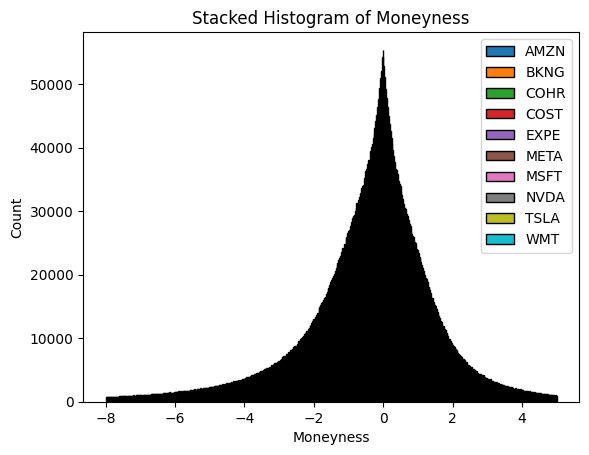

In [34]:
# Group the DataFrame by the 'ticker' column
grouped = pd_merged.groupby('Ticker')

# Create a list of data for each group
data = [group['moneyness'] for name, group in grouped]

# Create a list of labels for each group
labels = [name for name, group in grouped]

# Create a stacked histogram
plt.hist(data, bins=500, stacked=True, edgecolor='black', label=labels)

# Set the title and labels
plt.title('Stacked Histogram of Moneyness')
plt.xlabel('Moneyness')
plt.ylabel('Count')

# Set the x-limits
# plt.xlim(0, 2)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [35]:
pd_merged

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2019-01-02,2019-01-11,P,255000,0.95,0.99,320,193,0.814218,-0.054890,...,0.0,0.027778,2019-01-02,2.5442,310.339246,0.614092,-1.918955,1,5 < τ ≤ 20,-2 ≤ m < -0.5
1,2019-01-02,2019-01-18,C,119000,0.55,0.75,2,48,0.297967,0.177300,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.861277,1,5 < τ ≤ 20,0.5 < m ≤ 2
2,2019-01-02,2019-01-18,C,120000,0.40,0.60,22,2599,0.297155,0.143901,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,0.5 < m ≤ 2
3,2019-01-02,2019-01-18,P,120000,8.40,8.70,16,3202,0.320693,-0.841136,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,0.5 < m ≤ 2
4,2019-01-02,2019-01-18,C,130000,0.00,0.10,7,2532,0.332273,0.018084,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,2.139078,1,5 < τ ≤ 20,m > 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307415,2021-12-30,2021-12-31,P,1145000,74.80,76.40,45,180,0.783864,-0.947740,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.385904,756,τ ≤ 5,m > 2
5307416,2021-12-30,2021-12-31,C,1150000,0.38,0.39,33831,14807,0.700020,0.026135,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307417,2021-12-30,2021-12-31,P,1150000,79.80,81.40,343,567,0.823729,-0.949898,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307418,2021-12-30,2021-12-31,C,1155000,0.35,0.36,3587,1556,0.725706,0.023568,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.693742,756,τ ≤ 5,m > 2


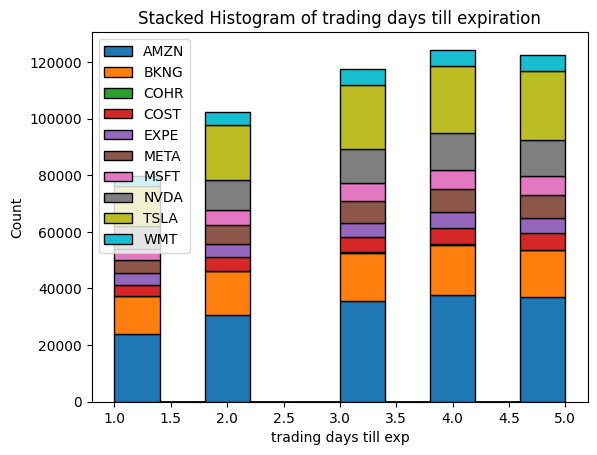

In [36]:
# Create the wished filted
# pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 6) & (pd_merged["m_category"] == "|m| ≤ 2")]
pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 5) & (pd_merged["m_category"] != "m < 2") & (pd_merged["m_category"] != "m > 2")]

# Group the DataFrame by the 'ticker' column
grouped = pd_maturity.groupby('Ticker')

# Create a list of data for each group
data = [group['trading_days_till_exp'] for name, group in grouped]

# Create a list of labels for each group
labels = [name for name, group in grouped]

# Create a stacked histogram
plt.hist(data, stacked=True, edgecolor='black', label=labels, width=0.4)

# Set the title and labels
plt.title('Stacked Histogram of trading days till expiration')
plt.xlabel('trading days till exp')
plt.ylabel('Count')

# Set the x-limits
# plt.xlim(0, 2)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [37]:
# Filter the DataFrame
pd_maturity = pd_merged[(pd_merged["trading_days_till_exp"] <= 5) & (pd_merged["m_category"] == "|m| ≤ 2")]

# Group the DataFrame by the 'ticker' and 'strike_price' columns and count the number of occurrences
grouped = pd_maturity.groupby(['Ticker', 'strike_price']).size().reset_index(name='counts')

# Calculate the average moneyness for each 'Ticker' and 'strike_price'
average_moneyness = pd_maturity.groupby(['Ticker', 'strike_price'])['moneyness'].mean().reset_index(name='average_moneyness')

# Calculate the total volume for each 'Ticker' and 'strike_price'
total_volume = pd_maturity.groupby(['Ticker', 'strike_price'])['volume'].sum().reset_index(name='total_volume')

# Merge the average moneyness and total volume with the grouped DataFrame
grouped = pd.merge(grouped, average_moneyness, on=['Ticker', 'strike_price'])
grouped = pd.merge(grouped, total_volume, on=['Ticker', 'strike_price'])

# Sort the DataFrame by 'total_volume' in descending order and then group by 'Ticker' to get the top 3 strike prices for each stock
top_strike_prices = grouped.sort_values('total_volume', ascending=False).groupby('Ticker').head(3)

# Print the top 3 strike prices for each stock along with the counts, average moneyness, and total volume
for ticker, group in top_strike_prices.groupby('Ticker'):
    print(f"Top 3 strike prices for {ticker}:")
    print(group[['strike_price', 'counts', 'average_moneyness', 'total_volume']])
    print("\n")

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/357412170.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



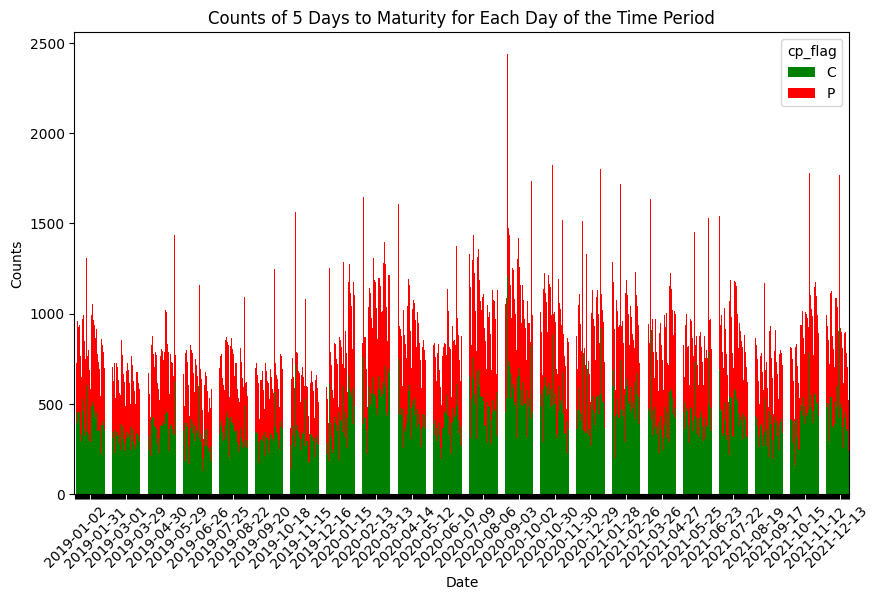

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame to only include rows where the trading days till expiration is 6
pd_maturity_6_days = pd_merged[pd_merged["trading_days_till_exp"] <= 5]

# Convert the 'date' column to just date without time
pd_maturity_6_days['date'] = pd.to_datetime(pd_maturity_6_days['date']).dt.date

# Group by the date and 'cp_flag' and count the number of occurrences
counts_by_date = pd_maturity_6_days.groupby(['date', 'cp_flag']).size().unstack(fill_value=0)

# Create a bar plot of the counts by date
ax = counts_by_date.plot(kind='bar', stacked=True, color=['green', 'red'], figsize=(10, 6), width=.8)

plt.title('Counts of 5 Days to Maturity for Each Day of the Time Period')
plt.xlabel('Date')
plt.ylabel('Counts')

# Rotate the x labels and only show every nth label
n = 20  # Show every nth label
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)
    label.set_rotation(45)

plt.show()

In [39]:
#Look at one moneyness specific
filtered_df_c = pd_merged[(pd_merged['trading_days_till_exp'] <= 5) & (pd_merged['moneyness'] >= 0) & (pd_merged['moneyness'] <= 0.5) & (pd_merged['volume'] > 0) & (pd_merged['cp_flag'] == 'C')]

selected_columns = ['Ticker', 'date', 'exdate', 'cp_flag', 'delta', 'impl_volatility', 'Prev_day_IV', 'atm_impl_volatility', 'trading_days_till_exp', 'moneyness']
filtered_df_c = filtered_df_c[selected_columns]
filtered_df_c = filtered_df_c.rename(columns={'trading_days_till_exp': 'tau'})

filtered_df_c.sort_values(by=['Ticker', 'date', 'exdate', 'tau'], inplace=True)

filtered_df_c


,Ticker,date,exdate,cp_flag,delta,impl_volatility,Prev_day_IV,atm_impl_volatility,tau,moneyness
3442,AMZN,2019-01-02,2019-01-04,C,0.481631,0.443802,0.505233,0.443327,2,0.050266
3444,AMZN,2019-01-02,2019-01-04,C,0.501305,0.443327,0.331166,0.443327,2,0.009196
3704,AMZN,2019-01-02,2019-01-04,C,0.461958,0.443189,0.368905,0.443327,2,0.091270
4000,AMZN,2019-01-02,2019-01-04,C,0.279619,0.443617,0.329599,0.443327,2,0.497696
4002,AMZN,2019-01-02,2019-01-04,C,0.296260,0.443834,0.502611,0.443327,2,0.457346
...,...,...,...,...,...,...,...,...,...,...
5305385,WMT,2021-12-27,2021-12-31,C,0.467034,0.171067,0.169905,0.171067,4,0.074206
5305404,WMT,2021-12-27,2021-12-31,C,0.323870,0.178364,0.165577,0.171067,4,0.402112
5305526,WMT,2021-12-28,2021-12-31,C,0.463931,0.167877,0.201037,0.167877,3,0.079760
5305528,WMT,2021-12-28,2021-12-31,C,0.298029,0.173454,0.188117,0.167877,3,0.460210


In [40]:
import pandas as pd
import plotly.graph_objects as go

# Create a copy of pd_merged
filtered_df_c_copy = filtered_df_c.copy()

# Convert the string to a pandas Timestamp
date = pd.Timestamp('2019-01-11')

# Use the copy for the filtering
pd_merged_3 = filtered_df_c_copy[(filtered_df_c_copy["tau"] <= 10) & (filtered_df_c_copy['cp_flag'] == 'C')]
# Filter the DataFrame for the 'NVDA' ticker and the specific date
df_nvda = pd_merged_3[(pd_merged_3['Ticker'] == 'AMZN')]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_nvda['moneyness'],
    y=df_nvda['tau'],
    z=df_nvda['impl_volatility'],
    mode='markers',
    marker=dict(
        size=3,
        color=df_nvda['impl_volatility'],  # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene = dict(
                    xaxis_title='Moneyness',
                    yaxis_title='Trading Days till Expiry',
                    zaxis_title='Implied Volatility'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [41]:
filtered_df_c['exdate'] = pd.to_datetime(filtered_df_c['exdate'])
train_data = filtered_df_c[filtered_df_c['exdate'].dt.year <= 2020]
test_data = filtered_df_c[filtered_df_c['exdate'].dt.year == 2021]

In [42]:
train_data

,Ticker,date,exdate,cp_flag,delta,impl_volatility,Prev_day_IV,atm_impl_volatility,tau,moneyness
3442,AMZN,2019-01-02,2019-01-04,C,0.481631,0.443802,0.505233,0.443327,2,0.050266
3444,AMZN,2019-01-02,2019-01-04,C,0.501305,0.443327,0.331166,0.443327,2,0.009196
3704,AMZN,2019-01-02,2019-01-04,C,0.461958,0.443189,0.368905,0.443327,2,0.091270
4000,AMZN,2019-01-02,2019-01-04,C,0.279619,0.443617,0.329599,0.443327,2,0.497696
4002,AMZN,2019-01-02,2019-01-04,C,0.296260,0.443834,0.502611,0.443327,2,0.457346
...,...,...,...,...,...,...,...,...,...,...
3566427,WMT,2020-12-23,2020-12-31,C,0.332719,0.186541,0.000000,0.192365,5,0.455782
3576448,WMT,2020-12-24,2020-12-31,C,0.438924,0.152029,0.000000,0.152029,4,0.181550
3585566,WMT,2020-12-28,2020-12-31,C,0.385852,0.197152,0.211791,0.196374,3,0.249964
3592128,WMT,2020-12-29,2020-12-31,C,0.373338,0.197559,0.251654,0.202319,2,0.268448


In [43]:
from sklearn.metrics import mean_absolute_error

# Group by 'Ticker', 'moneyness' and 'tau', then calculate the mean implied volatility
forecast = train_data.groupby(['Ticker', 'moneyness', 'tau'])['impl_volatility'].mean().reset_index()

# Pivot the table to have 'moneyness' and 'tau' as indices and 'Ticker' as columns
forecast_pivot = forecast.pivot_table(index=['moneyness', 'tau'], columns='Ticker', values='impl_volatility')

# Merge the test data with the forecast
merged = pd.merge(test_data, forecast, on=['Ticker', 'moneyness', 'tau'], how='left', suffixes=('_actual', '_forecast'))

# Calculate the MAE for each ticker, excluding rows with NaN values
mae = merged.dropna(subset=['impl_volatility_actual', 'impl_volatility_forecast']).groupby('Ticker').apply(lambda x: mean_absolute_error(x['impl_volatility_actual'], x['impl_volatility_forecast']))

# Print the ticker with the lowest MAE

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/2415703505.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [44]:
# Saving file 
option_data_path_parq = Path.cwd().parent / "Data/all_options_data.parquet"

save_parquet = True
if save_parquet or not os.path.exists(option_data_path_parq):
    pd_merged.to_parquet(option_data_path_parq)

## Group the moneyness on every trading day

In [45]:
#Read the file
df = pd.read_parquet(option_data_path_parq)

print(df.columns)
df

Index(['date', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer',
       'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega',
       'theta', 'Ticker', 'Prev_day_IV', 'trading_days_till_exp', 'PRC',
       'PRC_actual', 'Year', 'Annual_Dividend_Yield', 'T', 'DATE', '2Y_bond',
       'Forward_Price', 'atm_impl_volatility', 'moneyness', 'trading_day',
       'maturity_group', 'm_category'],
      dtype='object')


,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,...,Annual_Dividend_Yield,T,DATE,2Y_bond,Forward_Price,atm_impl_volatility,moneyness,trading_day,maturity_group,m_category
0,2019-01-02,2019-01-11,P,255000,0.95,0.99,320,193,0.814218,-0.054890,...,0.0,0.027778,2019-01-02,2.5442,310.339246,0.614092,-1.918955,1,5 < τ ≤ 20,-2 ≤ m < -0.5
1,2019-01-02,2019-01-18,C,119000,0.55,0.75,2,48,0.297967,0.177300,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.861277,1,5 < τ ≤ 20,0.5 < m ≤ 2
2,2019-01-02,2019-01-18,C,120000,0.40,0.60,22,2599,0.297155,0.143901,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,0.5 < m ≤ 2
3,2019-01-02,2019-01-18,P,120000,8.40,8.70,16,3202,0.320693,-0.841136,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,0.982223,1,5 < τ ≤ 20,0.5 < m ≤ 2
4,2019-01-02,2019-01-18,C,130000,0.00,0.10,7,2532,0.332273,0.018084,...,0.0,0.047619,2019-01-02,2.5442,112.115749,0.317068,2.139078,1,5 < τ ≤ 20,m > 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5307415,2021-12-30,2021-12-31,P,1145000,74.80,76.40,45,180,0.783864,-0.947740,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.385904,756,τ ≤ 5,m > 2
5307416,2021-12-30,2021-12-31,C,1150000,0.38,0.39,33831,14807,0.700020,0.026135,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307417,2021-12-30,2021-12-31,P,1150000,79.80,81.40,343,567,0.823729,-0.949898,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.540158,756,τ ≤ 5,m > 2
5307418,2021-12-30,2021-12-31,C,1155000,0.35,0.36,3587,1556,0.725706,0.023568,...,0.0,0.003968,2021-12-30,0.8076,1070.374272,0.448418,2.693742,756,τ ≤ 5,m > 2


In [46]:
test_df = df[['m_category', 'maturity_group', 'cp_flag', 'date', 'exdate']]

In [47]:
test_df

,m_category,maturity_group,cp_flag,date,exdate
0,-2 ≤ m < -0.5,5 < τ ≤ 20,P,2019-01-02,2019-01-11
1,0.5 < m ≤ 2,5 < τ ≤ 20,C,2019-01-02,2019-01-18
2,0.5 < m ≤ 2,5 < τ ≤ 20,C,2019-01-02,2019-01-18
3,0.5 < m ≤ 2,5 < τ ≤ 20,P,2019-01-02,2019-01-18
4,m > 2,5 < τ ≤ 20,C,2019-01-02,2019-01-18
...,...,...,...,...,...
5307415,m > 2,τ ≤ 5,P,2021-12-30,2021-12-31
5307416,m > 2,τ ≤ 5,C,2021-12-30,2021-12-31
5307417,m > 2,τ ≤ 5,P,2021-12-30,2021-12-31
5307418,m > 2,τ ≤ 5,C,2021-12-30,2021-12-31


In [48]:
grouped_df = test_df.groupby(['m_category', 'maturity_group', 'cp_flag', 'date', 'exdate']).count()

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_37784/900909306.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [49]:
grouped_df

Empty DataFrame
Columns: []
Index: [(-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-01-04 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-01-11 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-01-18 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-01-25 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-02-01 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-02-08 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-02-15 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-02-22 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-03-01 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-03-08 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-03-15 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-03-22 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-03-29 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-04-05 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-04-12 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-04-18 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-04-26 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-05-03 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-05-10 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-05-17 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-05-24 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-05-31 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-06-07 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-06-14 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-06-21 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-06-28 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-07-05 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-07-12 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-07-19 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-07-26 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-08-02 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-08-09 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-08-16 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-08-23 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-08-30 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-09-06 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-09-13 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-09-20 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-09-27 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-10-04 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-10-11 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-10-18 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-10-25 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-11-01 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-11-08 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-11-15 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-11-22 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-11-29 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-12-06 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-12-13 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-12-20 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2019-12-27 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2020-01-03 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2020-01-10 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2020-01-17 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2020-01-24 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2020-01-31 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5, C, 2019-01-02 00:00:00, 2020-02-07 00:00:00), (-0.5 < m ≤ 0, τ ≤ 5